In [ ]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id="xingjunm/WildDeepfake",
    repo_type="dataset",
    local_dir="./WildDeepfake"
)

<h2>Build Dataset</h2>

In [ ]:


from prepare_data import WildDeepfakePreparator


preparator = WildDeepfakePreparator(
    data_root=DATA_ROOT,
    output_root="./dataset"
)


preparator.select_num = {
    "fake_train": NUM_FAKE_TRAIN,
    "real_train": NUM_REAL_TRAIN,
    "fake_test": NUM_FAKE_TEST,
    "real_test": NUM_REAL_TEST,
}


dataset_info = preparator.run()

<h2>paramaters</h2>

In [2]:
import torch

DATA_ROOT = "../WildDeepfake"          
DATASET_JSON = "./dataset/dataset.json"  

NUM_FAKE_TRAIN = 50 
NUM_REAL_TRAIN = 50 
NUM_FAKE_TEST = 30  
NUM_REAL_TEST = 30  


MODEL_TYPE = "base" 
PRETRAINED = True   
FREEZE_VIT = False  


NUM_FRAMES = 48     
IMAGE_SIZE = 224    
BATCH_SIZE = 16     
EPOCHS = 10         
LR = 1e-4           
WEIGHT_DECAY = 0.1  
WARMUP_EPOCHS = 3   
NUM_WORKERS = 2     


OUTPUT_DIR = "./checkpoints"

# 设备
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {DEVICE}")

使用设备: cuda


<h2>check dataset</h2>

In [ ]:
import json
from collections import defaultdict
import random

random.seed(42) 


with open(DATASET_JSON, "r") as f:
    dataset = json.load(f)

test_samples = dataset["test"]
print(len(test_samples))

by_label = defaultdict(list)
for s in test_samples:
    by_label[s["label"]].append(s)


val_samples = []
new_test_samples = []

for label, samples in by_label.items():
    random.shuffle(samples)
    split_idx = len(samples) // 2
    val_samples.extend(samples[:split_idx])
    new_test_samples.extend(samples[split_idx:])


dataset["val"] = val_samples
dataset["test"] = new_test_samples


with open(DATASET_JSON, "w") as f:
    json.dump(dataset, f, indent=2)

print("数据集统计:")
print("=" * 40)
for split in ["train", "val", "test"]:
    samples = dataset[split]
    real_count = sum(1 for s in samples if s["label"] == 0)
    fake_count = sum(1 for s in samples if s["label"] == 1)
    total_frames = sum(s["num_frames"] for s in samples)
    
    print(f"\n{split.upper()}:")
    print(f"  序列数: {len(samples)}")
    print(f"  Real: {real_count}, Fake: {fake_count}")
    print(f"  总帧数: {total_frames}")
    print(f"  平均帧数: {total_frames / len(samples):.1f}")


In [ ]:

import matplotlib.pyplot as plt

train_frames = [s["num_frames"] for s in dataset["train"]]

plt.figure(figsize=(10, 4))
plt.hist(train_frames, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Number of Frames")
plt.ylabel("Count")
plt.title("Frame Distribution in Training Set")
plt.axvline(x=NUM_FRAMES, color='r', linestyle='--', label=f'Sampling: {NUM_FRAMES} frames')
plt.legend()
plt.show()

print(f"帧数 < {NUM_FRAMES} 的序列: {sum(1 for f in train_frames if f < NUM_FRAMES)}")

<h2>DataLoader</h2>

In [3]:
from deepfake_dataset import create_dataloaders, DeepfakeDataset


train_loader, test_loader, val_loader = create_dataloaders(
    json_path=DATASET_JSON,
    batch_size=32,
    num_frames=24,
    image_size=IMAGE_SIZE,
    num_workers=NUM_WORKERS,
    sampling="consecutive",
)

print(f"\n训练集 batches: {len(train_loader)}")
print(f"测试集 batches: {len(test_loader)}")
print(f"val batches: {len(val_loader)}")

[train] 加载 2265 个序列 (过滤掉帧数<8的)
[test] 加载 381 个序列 (过滤掉帧数<8的)
[val] 加载 381 个序列 (过滤掉帧数<8的)

训练集 batches: 70
测试集 batches: 12
val batches: 12


In [4]:

videos, labels = next(iter(train_loader))
print(f"Videos shape: {videos.shape}")  # (B, T, C, H, W)
print(f"Labels: {labels}")

Videos shape: torch.Size([32, 24, 3, 224, 224])
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1])


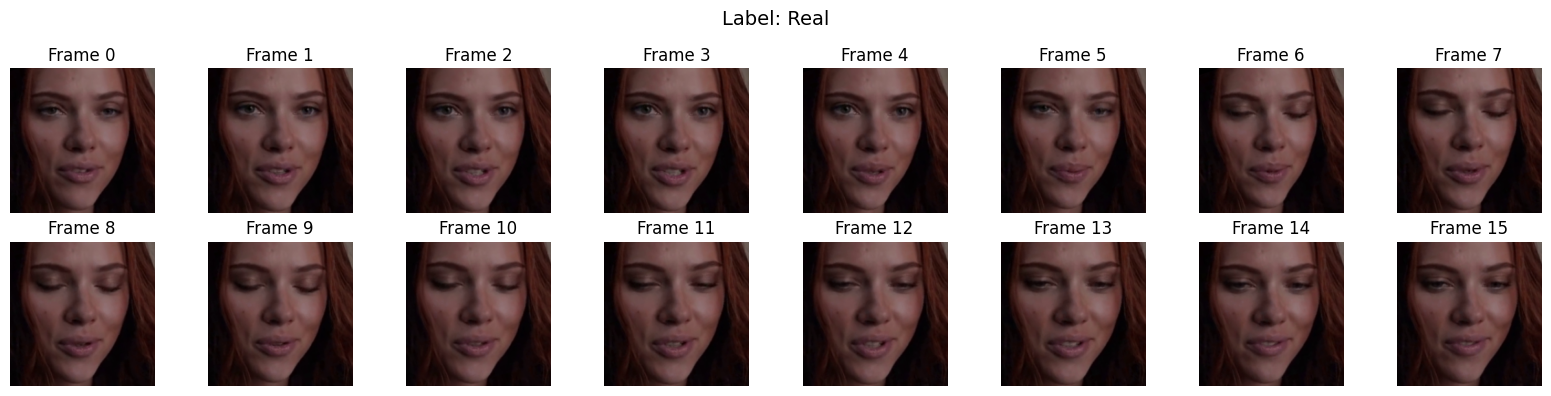

In [5]:

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def denormalize(tensor):

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean


sample_video = videos[0]  # (T, C, H, W)
sample_label = labels[0].item()


fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    if i < len(sample_video):
        img = denormalize(sample_video[i]).permute(1, 2, 0).numpy()
        img = img.clip(0, 1)
        ax.imshow(img)
        ax.set_title(f"Frame {i}")
    ax.axis("off")

plt.suptitle(f"Label: {'Fake' if sample_label == 1 else 'Real'}", fontsize=14)
plt.tight_layout()
plt.show()

<h2>Model</h2>

In [6]:
from model import create_model


model = create_model(
    model_type="base",
    pretrained=PRETRAINED,
    freeze_vit=False,
    num_classes=2,
    temporal_dropout = 0.3,
    dropout = 0.4,
    temporal_num_heads = 8,
    temporal_num_layers = 4,
    use_temporal_pos_embed = False
)

model = model.to(DEVICE)


创建模型: base
  ViT: vit_base_patch16_224
  Temporal layers: 4

模型参数统计:
  总参数量: 114.45M
  可训练参数: 114.45M
  特征维度: 768


/home/zihanl19/.conda/envs/cat-env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:

with torch.no_grad():
    test_input = videos[:2].to(DEVICE)
    test_output = model(test_input)
    print(f"输入: {test_input.shape}")
    print(f"输出: {test_output.shape}")
    print(f"预测: {test_output.argmax(dim=1)}")

输入: torch.Size([2, 24, 3, 224, 224])
输出: torch.Size([2, 2])
预测: tensor([1, 1], device='cuda:0')


<h2>Train</h2>

In [8]:
from train import Trainer


trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=DEVICE,
    output_dir=OUTPUT_DIR,
    lr=3e-5,
    weight_decay=0.1,
    epochs=10,
    warmup_epochs=5,
    use_amp=True,
    # Focal Loss 设置
    loss_type="focal",    
    focal_gamma=2.0,    
    class_weights="balanced",
)


类别分布: Real=1349, Fake=916
类别权重: Real=0.840, Fake=1.236
Loss 类型: focal
Focal Loss gamma=2.0


In [9]:

history = trainer.train()

开始训练
设备: cuda
训练集大小: 2265
测试集大小: 381
Batch size: 32
Epochs: 10
混合精度: True
输出目录: checkpoints


Epoch 1 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.40s/it]


  Real 准确率: 53.03%
  Fake 准确率: 63.39%
  Balanced Acc: 58.21%
  保存最佳模型: checkpoints/best.pth

Epoch 1/10 完成 (333.3s)
  Train Loss: 0.1875, Train Acc: 54.42%
  Test Loss: 0.1692, Test Acc: 58.01%
  Balanced Acc: 58.21% (Best: 58.21%)
------------------------------------------------------------


Epoch 2 [Test]: 100%|██████████| 12/12 [00:29<00:00,  2.47s/it]


  Real 准确率: 97.98%
  Fake 准确率: 16.94%
  Balanced Acc: 57.46%

Epoch 2/10 完成 (337.3s)
  Train Loss: 0.1599, Train Acc: 65.58%
  Test Loss: 0.2348, Test Acc: 59.06%
  Balanced Acc: 57.46% (Best: 58.21%)
------------------------------------------------------------


Epoch 3 [Test]: 100%|██████████| 12/12 [00:29<00:00,  2.45s/it]


  Real 准确率: 100.00%
  Fake 准确率: 16.94%
  Balanced Acc: 58.47%
  保存最佳模型: checkpoints/best.pth

Epoch 3/10 完成 (343.0s)
  Train Loss: 0.1226, Train Acc: 76.70%
  Test Loss: 0.3386, Test Acc: 60.10%
  Balanced Acc: 58.47% (Best: 58.47%)
------------------------------------------------------------


Epoch 4 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.39s/it]


  Real 准确率: 98.48%
  Fake 准确率: 31.69%
  Balanced Acc: 65.09%
  保存最佳模型: checkpoints/best.pth

Epoch 4/10 完成 (340.3s)
  Train Loss: 0.0976, Train Acc: 84.46%
  Test Loss: 0.3408, Test Acc: 66.40%
  Balanced Acc: 65.09% (Best: 65.09%)
------------------------------------------------------------


Epoch 5 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.32s/it]


  Real 准确率: 72.22%
  Fake 准确率: 80.33%
  Balanced Acc: 76.28%
  保存最佳模型: checkpoints/best.pth

Epoch 5/10 完成 (345.2s)
  Train Loss: 0.0776, Train Acc: 88.57%
  Test Loss: 0.1702, Test Acc: 76.12%
  Balanced Acc: 76.28% (Best: 76.28%)
------------------------------------------------------------


Epoch 6 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.33s/it]


  Real 准确率: 97.47%
  Fake 准确率: 39.89%
  Balanced Acc: 68.68%

Epoch 6/10 完成 (332.7s)
  Train Loss: 0.0688, Train Acc: 90.40%
  Test Loss: 0.3122, Test Acc: 69.82%
  Balanced Acc: 68.68% (Best: 76.28%)
------------------------------------------------------------


Epoch 7 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.32s/it]


  Real 准确率: 91.41%
  Fake 准确率: 57.38%
  Balanced Acc: 74.40%

Epoch 7/10 完成 (324.7s)
  Train Loss: 0.0518, Train Acc: 92.86%
  Test Loss: 0.3115, Test Acc: 75.07%
  Balanced Acc: 74.40% (Best: 76.28%)
------------------------------------------------------------


Epoch 8 [Test]: 100%|██████████| 12/12 [00:29<00:00,  2.50s/it]


  Real 准确率: 87.88%
  Fake 准确率: 67.21%
  Balanced Acc: 77.55%
  保存最佳模型: checkpoints/best.pth

Epoch 8/10 完成 (332.1s)
  Train Loss: 0.0268, Train Acc: 96.83%
  Test Loss: 0.3010, Test Acc: 77.95%
  Balanced Acc: 77.55% (Best: 77.55%)
------------------------------------------------------------


Epoch 9 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.35s/it]


  Real 准确率: 88.38%
  Fake 准确率: 69.95%
  Balanced Acc: 79.16%
  保存最佳模型: checkpoints/best.pth

Epoch 9/10 完成 (332.9s)
  Train Loss: 0.0157, Train Acc: 98.04%
  Test Loss: 0.3100, Test Acc: 79.53%
  Balanced Acc: 79.16% (Best: 79.16%)
------------------------------------------------------------


Epoch 10 [Test]: 100%|██████████| 12/12 [00:30<00:00,  2.52s/it]


  Real 准确率: 91.41%
  Fake 准确率: 66.67%
  Balanced Acc: 79.04%

Epoch 10/10 完成 (330.2s)
  Train Loss: 0.0121, Train Acc: 98.71%
  Test Loss: 0.3635, Test Acc: 79.53%
  Balanced Acc: 79.04% (Best: 79.16%)
------------------------------------------------------------

训练完成！总耗时: 0.93小时
最佳 Balanced Accuracy: 79.16%


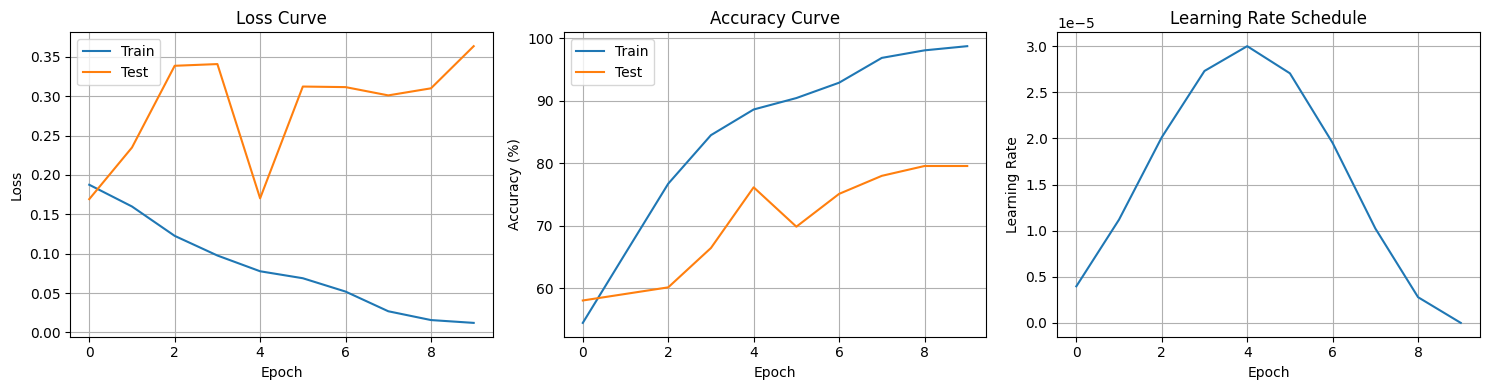


最佳测试准确率: 79.53%


In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


axes[0].plot(history["train_loss"], label="Train")
axes[0].plot(history["test_loss"], label="Test")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curve")
axes[0].legend()
axes[0].grid(True)


axes[1].plot(history["train_acc"], label="Train")
axes[1].plot(history["test_acc"], label="Test")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Accuracy Curve")
axes[1].legend()
axes[1].grid(True)


axes[2].plot(history["lr"])
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Learning Rate")
axes[2].set_title("Learning Rate Schedule")
axes[2].grid(True)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/training_curves.png", dpi=150)
plt.show()

print(f"\n最佳测试准确率: {max(history['test_acc']):.2f}%")

In [11]:

best_checkpoint = torch.load(f"{OUTPUT_DIR}/best.pth", map_location=DEVICE)
model.load_state_dict(best_checkpoint["model_state_dict"])
print(f"加载最佳模型，来自 Epoch {best_checkpoint['epoch'] + 1}")


加载最佳模型，来自 Epoch 9


分类报告:
              precision    recall  f1-score   support

        Real       0.75      0.90      0.82       198
        Fake       0.86      0.68      0.76       183

    accuracy                           0.79       381
   macro avg       0.81      0.79      0.79       381
weighted avg       0.80      0.79      0.79       381



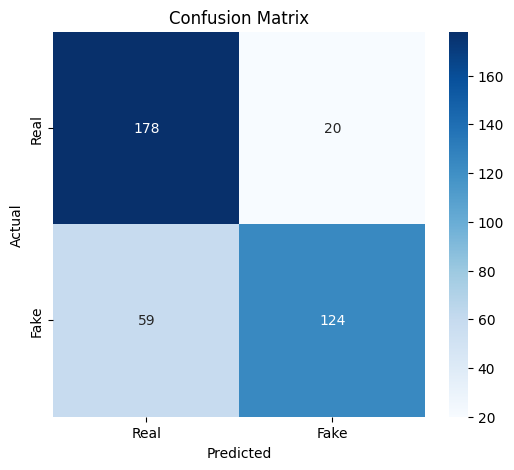

In [12]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in val_loader:
        videos = videos.to(DEVICE)
        outputs = model(videos)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())


print("分类报告:")
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", dpi=150)
plt.show()

In [13]:
import numpy as np
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

overall_acc = (all_preds == all_labels).mean() * 100
print(f"\nVAL Overall Accuracy: {overall_acc:.2f}%  ({(all_preds==all_labels).sum()}/{len(all_labels)})")



VAL Overall Accuracy: 79.27%  (302/381)
